In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_mlps.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [10]:
class CNNEncoding:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.feature = None
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Conv1D(32, 3, activation='relu')(inputs)
        x = MaxPooling1D(2)(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        self.features = Dense(16, activation='relu')(x)
        output = Dense(1, activation='linear')(x)
        
        model = Model(inputs, output, name='model1')
        return model
input_shape=(len(X_train.columns),1)
cnn_model=CNNEncoding(input_shape=input_shape)
cnn_model.model.load_weights('weights/cnn.hdf5')
cnn_model.model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                102464    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                            

In [11]:
class MLPsClassification:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()
        
    def build_model(self):
        print(input_shape)
        inputs = Input(shape=self.input_shape)
        x = Dense(units=64, activation='relu')(inputs)  # Adjust units and other parameters as needed
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(units=128, activation='relu')(x)
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(units=64, activation='relu')(x)
        x=BatchNormalization()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(units=1, activation='linear')(x)
        model = Model(inputs, outputs, name='model2')
        return model
input_dim = (16,1)

mlps_classification = MLPsClassification(input_shape=input_dim)
mlps_classification.model.summary()

(102, 1)
Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 dense_3 (Dense)             (None, 16, 64)            128       
                                                                 
 batch_normalization (Batch  (None, 16, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 16, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 16, 128)           8320      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 128)           512       
 chNormalization)                                  

In [12]:
# mlps_classification.model.load_weights('weights/mlps.hdf5')


In [13]:
class CNN_MLPs:
    def __init__(self, input_shape,encoder, classification, lr=0.0001):
        self.input_shape = input_shape
        self.model1 = encoder.model
        self.feature_shape = (encoder.features.shape[1],)
        self.features=encoder.features
        self.model2 = classification.model
        self.lr = lr
        self.model = self.build_model()
        
    def build_model(self):
        combined_input = self.model1.input
        output = self.model2(self.features)
        combined_model = Model(inputs=combined_input, outputs=output, name='combined_model')
        combined_model.compile(optimizer=Adam(learning_rate=self.lr), loss='mae', metrics=['mae', r2])
        return combined_model

In [14]:
model =CNN_MLPs(input_shape=input_shape,encoder=cnn_model, classification=mlps_classification).model
model.summary()


Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                102464    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                    

In [15]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.2658 - mae: 0.2658 - r2: -38.2535INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 1: val_loss improved from inf to 0.19780, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 480s 27ms/step - loss: 0.2658 - mae: 0.2658 - r2: -38.2535 - val_loss: 0.1978 - val_mae: 0.1978 - val_r2: -7.4926 - lr: 1.0000e-04
Epoch 2/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1917 - mae: 0.1917 - r2: -10.8272
Epoch 2: val_loss did not improve from 0.19780
16982/16982 [==============================] - 454s 27ms/step - loss: 0.1917 - mae: 0.1917 - r2: -10.8272 - val_loss: 0.2060 - val_mae: 0.2060 - val_r2: -8.7184 - lr: 1.0000e-04
Epoch 3/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1869 - mae: 0.1869 - r2: -10.4569INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 3: val_loss improved from 0.19780 to 0.19275, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 444s 26ms/step - loss: 0.1869 - mae: 0.1869 - r2: -10.4565 - val_loss: 0.1927 - val_mae: 0.1927 - val_r2: -6.6020 - lr: 1.0000e-04
Epoch 4/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1820 - mae: 0.1820 - r2: -9.3138INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 4: val_loss improved from 0.19275 to 0.17905, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 464s 27ms/step - loss: 0.1820 - mae: 0.1820 - r2: -9.3136 - val_loss: 0.1791 - val_mae: 0.1791 - val_r2: -5.6768 - lr: 1.0000e-04
Epoch 5/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1793 - mae: 0.1793 - r2: -8.8983INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 5: val_loss improved from 0.17905 to 0.17572, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 497s 29ms/step - loss: 0.1793 - mae: 0.1793 - r2: -8.8983 - val_loss: 0.1757 - val_mae: 0.1757 - val_r2: -5.3448 - lr: 1.0000e-04
Epoch 6/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1771 - mae: 0.1771 - r2: -8.5999
Epoch 6: val_loss did not improve from 0.17572
16982/16982 [==============================] - 458s 27ms/step - loss: 0.1771 - mae: 0.1771 - r2: -8.5999 - val_loss: 0.1904 - val_mae: 0.1904 - val_r2: -6.2411 - lr: 1.0000e-04
Epoch 7/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1748 - mae: 0.1748 - r2: -8.3919
Epoch 7: val_loss did not improve from 0.17572
16982/16982 [==============================] - 469s 28ms/step - loss: 0.1748 - mae: 0.1748 - r2: -8.3917 - val_loss: 0.1793 - val_mae: 0.1793 - val_r2: -5.4730 - lr: 1.0000e-04
Epoch 8/10000
16980/16982 [========================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 13: val_loss improved from 0.17572 to 0.15512, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 471s 28ms/step - loss: 0.1696 - mae: 0.1696 - r2: -7.7441 - val_loss: 0.1551 - val_mae: 0.1551 - val_r2: -4.3200 - lr: 5.0000e-05
Epoch 14/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1685 - mae: 0.1685 - r2: -7.6452
Epoch 14: val_loss did not improve from 0.15512
16982/16982 [==============================] - 431s 25ms/step - loss: 0.1684 - mae: 0.1684 - r2: -7.6453 - val_loss: 0.1883 - val_mae: 0.1883 - val_r2: -6.1470 - lr: 5.0000e-05
Epoch 15/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1686 - mae: 0.1686 - r2: -7.6090
Epoch 15: val_loss did not improve from 0.15512
16982/16982 [==============================] - 365s 21ms/step - loss: 0.1686 - mae: 0.1686 - r2: -7.6086 - val_loss: 0.1713 - val_mae: 0.1713 - val_r2: -5.0723 - lr: 5.0000e-05
Epoch 16/10000
16980/16982 [==================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_120507-4fflqlbx\files\model-best)... Done. 0.1s



Epoch 19: val_loss improved from 0.15512 to 0.15399, saving model to best_model_cnn_mlps.weights.h5
16982/16982 [==============================] - 407s 24ms/step - loss: 0.1654 - mae: 0.1654 - r2: -7.3347 - val_loss: 0.1540 - val_mae: 0.1540 - val_r2: -3.8359 - lr: 5.0000e-05
Epoch 20/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1649 - mae: 0.1649 - r2: -7.2580
Epoch 20: val_loss did not improve from 0.15399
16982/16982 [==============================] - 366s 22ms/step - loss: 0.1649 - mae: 0.1649 - r2: -7.2577 - val_loss: 0.1837 - val_mae: 0.1837 - val_r2: -5.5005 - lr: 5.0000e-05
Epoch 21/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1650 - mae: 0.1650 - r2: -7.3707
Epoch 21: val_loss did not improve from 0.15399
16982/16982 [==============================] - 373s 22ms/step - loss: 0.1650 - mae: 0.1650 - r2: -7.3703 - val_loss: 0.1856 - val_mae: 0.1856 - val_r2: -5.6906 - lr: 5.0000e-05
Epoch 22/10000
16980/16982 [==================

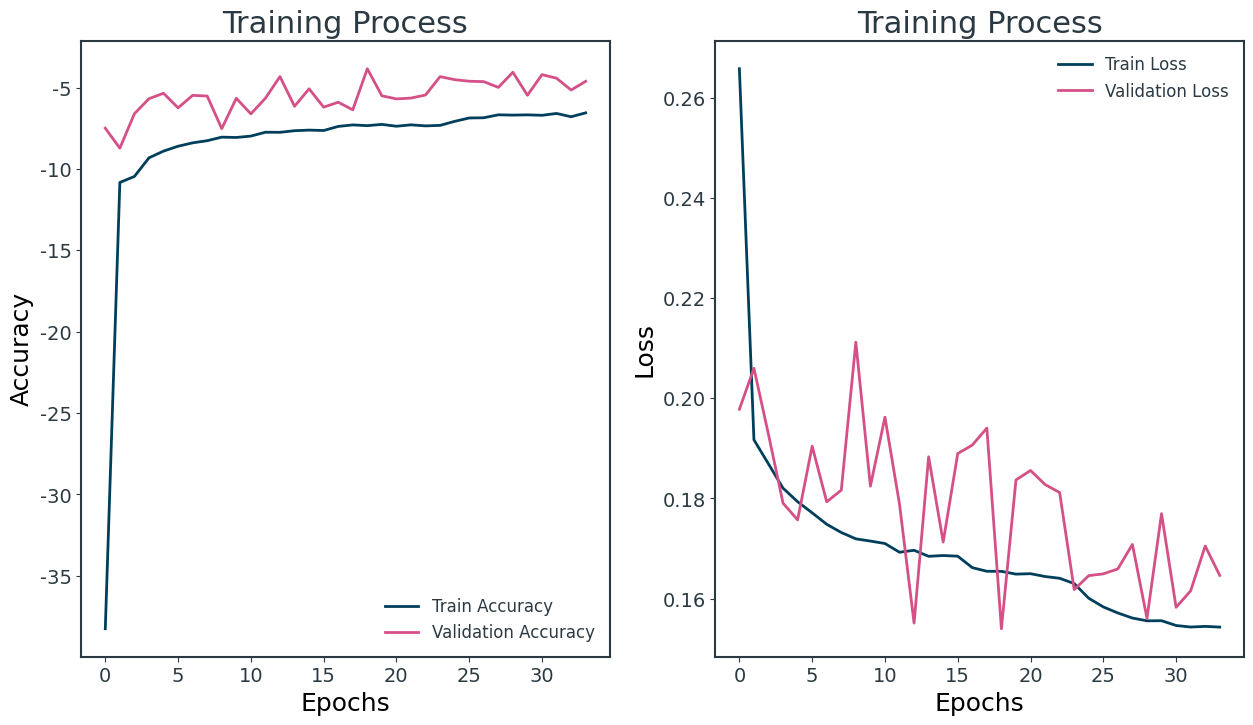

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [17]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.26578882336616516, 0.19169868528842926, 0.18688692152500153, 0.18204283714294434, 0.1793459802865982, 0.1771274358034134, 0.17484207451343536, 0.173200324177742, 0.17193546891212463, 0.17148859798908234, 0.17100299894809723, 0.1692567616701126, 0.1696467399597168, 0.16844849288463593, 0.1686042845249176, 0.16847452521324158, 0.16618356108665466, 0.1654594987630844, 0.16544359922409058, 0.1648915708065033, 0.16497787833213806, 0.16441182792186737, 0.1640615165233612, 0.16300560534000397, 0.16007578372955322, 0.15834113955497742, 0.1571328043937683, 0.1561230719089508, 0.15556661784648895, 0.15558955073356628, 0.15463492274284363, 0.154327854514122, 0.15445691347122192, 0.1543165147304535]
[0.19780386984348297, 0.2059863805770874, 0.1927483230829239, 0.17905199527740479, 0.17571952939033508, 0.19042253494262695, 0.17932774126529694, 0.18165847659111023, 0.21119751036167145, 0.18245624005794525, 0.19621481001377106

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")




16729/16729 [==============================] - 36s 2ms/step


ValueError: Found array with dim 3. None expected <= 2.